In [1]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.resnet_v2 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16,VGG19,ResNet101V2
from keras.models import Model



# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score,roc_curve,roc_auc_score


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/dataset_sup_new.zip" -d '/content/dataset'

Archive:  /content/drive/My Drive/dataset_sup_new.zip
   creating: /content/dataset/dataset_sup/
   creating: /content/dataset/dataset_sup/test/
   creating: /content/dataset/dataset_sup/test/caricature/
  inflating: /content/dataset/dataset_sup/test/caricature/001.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/004.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/007.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/008.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/012.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/020.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/022.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/026.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/028.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/031.jpg  
  inflating: /content/dataset/dataset_sup/test/caricature/033.jpg  
  inflating: /content/dataset/dataset_sup/test/c

In [4]:
model = tf.keras.models.load_model('/content/drive/My Drive/PMA/max_pooling_resnet.h5')

In [24]:
#model = tf.keras.models.load_model('/content/drive/My Drive/model_resnet_new_data.h5')

In [21]:
test_dir = '/content/dataset/dataset_sup/test/'
train_dir = '/content/dataset/dataset_sup/train/' 

In [22]:
class_label = ['manifestation','famille','caricature','texte']

In [7]:
dict_train = {}
for i,l in enumerate(class_label) : 
  img = load_img(train_dir+class_label[i]+'/'+os.listdir(train_dir+class_label[i])[np.random.randint(0,100)], target_size=(224,224))
  # convertir l'image en numpy
  img = np.array(img) 
  # batch_size = 1, taille = 224x224 , channel = 3
  reshaped_img = img.reshape(224,224,3) 
  #imgx = preprocess_input(reshaped_img)
  # passage vers le modele
  dict_train[i] = reshaped_img



In [8]:
dict_test = {}
for i,l in enumerate(class_label) : 
  img = load_img(test_dir+class_label[i]+'/'+os.listdir(test_dir+class_label[i])[np.random.randint(0,100)], target_size=(224,224))
  # convertir l'image en numpy
  img = np.array(img) 
  # batch_size = 1, taille = 224x224 , channel = 3
  reshaped_img = img.reshape(224,224,3) 
  # passage vers le modele
  imgx = preprocess_input(reshaped_img)

  dict_test[i] = reshaped_img

In [9]:
x_test_each_class = [dict_test[i] for i in sorted(dict_test)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0     

In [23]:
images_dict = dict(sorted(dict_train.items()))


In [26]:
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 5, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_label[k], class_label[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

In [13]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [52]:
x_train = tf.keras.utils.image_dataset_from_directory('/content/dataset/dataset_sup/train',
                                                            shuffle=True,
                                                            image_size=(224,224))

Found 2400 files belonging to 4 classes.


In [14]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = img_gen.flow_from_directory('/content/dataset/dataset_sup/train',target_size=(224,224))
x_train, labels = next(train_data)

Found 2400 images belonging to 4 classes.


In [18]:

import shap 

# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 32)]
# DeepExplainer to explain predictions of the model
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
explainer = shap.DeepExplainer(model, background)
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


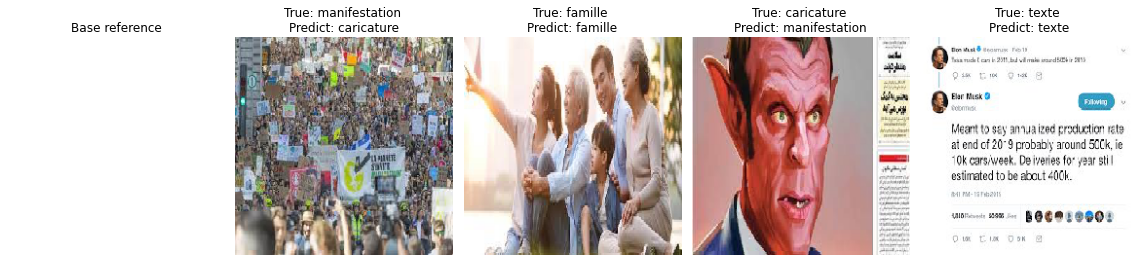

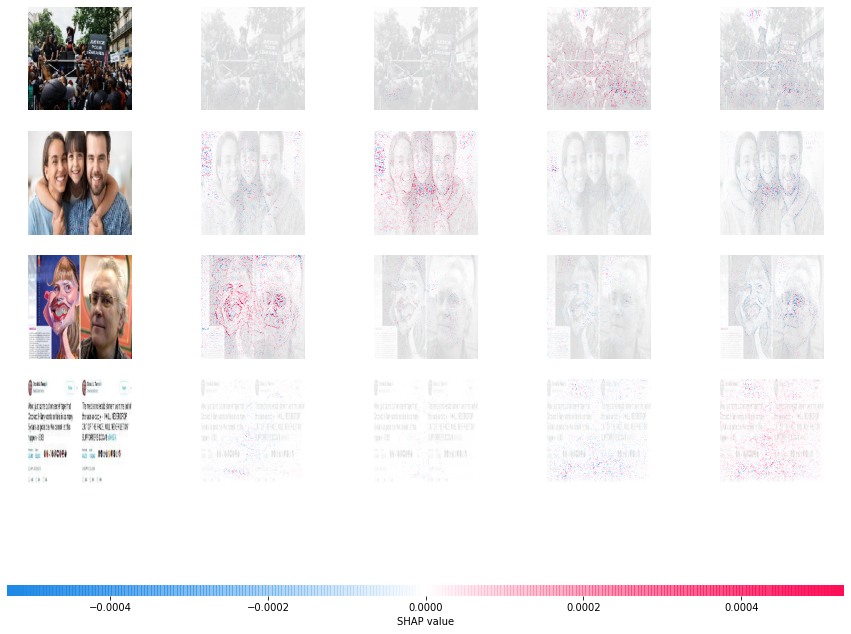

In [27]:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class )

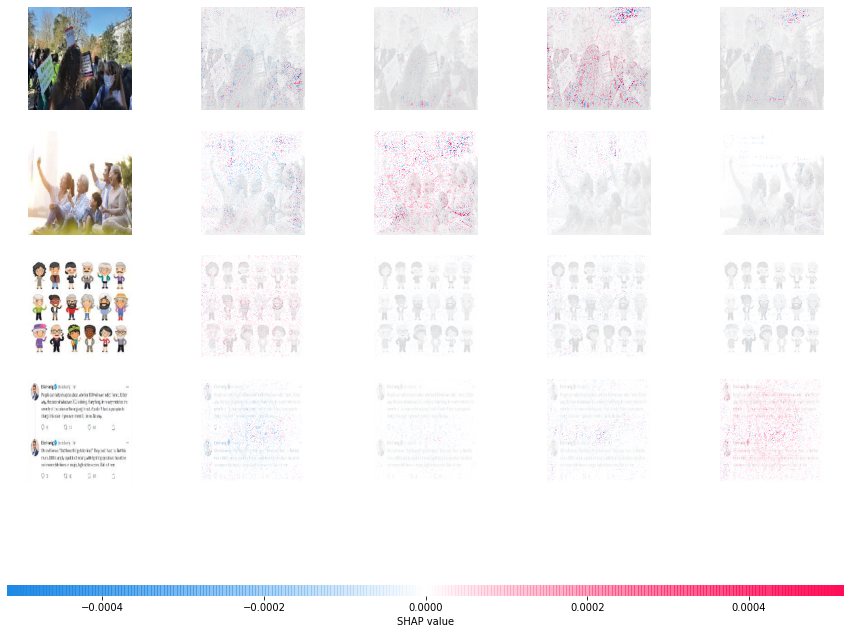

In [25]:
shap.image_plot(shap_values, x_test_each_class)


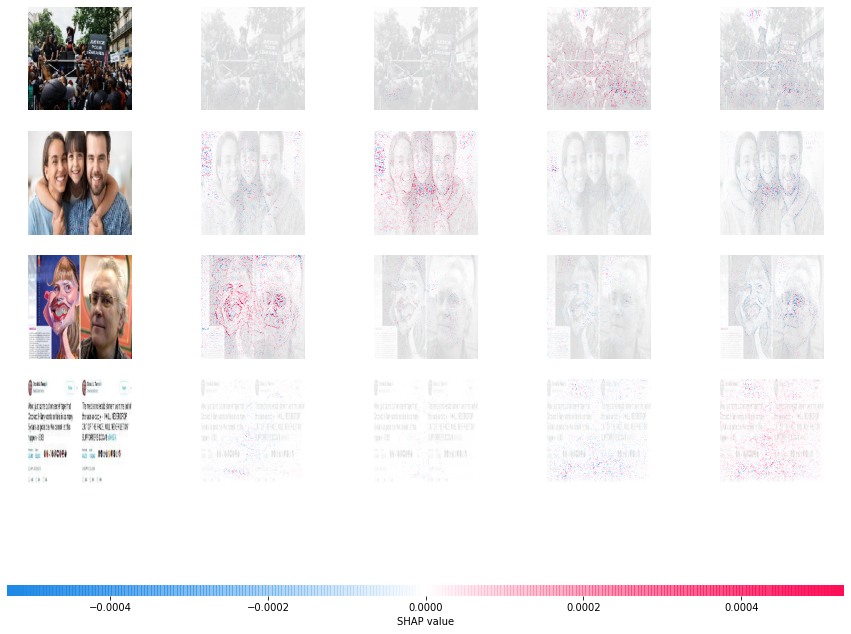

In [20]:
shap.image_plot(shap_values, x_test_each_class)
